In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import metpy.calc as mp
from metpy.units import units
from windrose import WindroseAxes
import matplotlib.cm as cm
from glob import glob 
from evFileProcessing import evFuncs
import matplotlib.dates as mdates
# -*- coding: utf-8 -*-

def pmelTransport(files):
    bigDs = []
    for file in files:
        ds = xr.open_dataset(file,decode_times=False)
        times = ds.time.values+ds.time2.values/1000/60/60/24
        t2 = [Time(time,format='jd').iso for time in times]
        ds['time3'] = pd.to_datetime(t2)
        ds = ds.where(ds.v_1206<1000)
        bigDs.append(pd.DataFrame({'time':ds.time3.values,'uADCP':np.concatenate(np.concatenate(ds.u_1205.mean(dim='depth').values,axis=0))/100,'vADCP':np.concatenate(np.concatenate(ds.v_1206.mean(dim='depth').values,axis=0))/100}).set_index('time'))
    return pd.concat(bigDs)

def readTracks(file):
    dfTracks = pd.read_csv(file)
    dfTracks['Date_S'] = dfTracks['Date_S'].astype(str)
    dfTracks['Datetime'] = pd.to_datetime(dfTracks['Date_S'] + ' ' + dfTracks['Time_S'])
    dfTracks = dfTracks.drop(['Date_S','Time_S'], axis=1)
    dfTracks = dfTracks.set_index('Datetime')
    return dfTracks

def uv(wspd, wdir):
    rad = 4.0*np.arctan(1)/180.
    wdir = wdir-180
    u = -wspd*np.sin(rad*wdir)
    v = -wspd*np.cos(rad*wdir)
    return round(u,3),round(v,3)

def rotUV(u,v,rot):
    v1 = (-u*np.sin(rot*np.pi/180))+(v*np.cos(rot*np.pi/180))
    u1 = (u*np.cos(rot*np.pi/180))+(v*np.sin(rot*np.pi/180))
    return u1,v1

def uvDir(u,v): 
    head = (90-np.rad2deg(np.arctan2(v,u)))
    return head

def combF(df, dfT,dfADCP,depth,rotate = False,deg = 0):
    dfT['SigBS_mean'] = 10**(dfT.TS_mean/10)
    dfT = dfT.resample('2H').mean()[['linearHead','linearSpeed','SigBS_mean']]
    df = df.resample('2H').sum()
    df['sa'] = df.sA/(4*np.pi*(1852**2))
    dfComb = df.join(dfT)
    dfComb['abund'] = dfComb.sa/dfComb.SigBS_mean
    if deg == 0:
        cts,binL = np.histogram(dfComb.linearHead,bins=36,range=[0,360])
        binL = binL[:-1]
        deg = binL[cts == cts.max()].mean()+5
    dfComb['rotateHead'] = dfComb.linearHead-(deg)
    print(deg)
    u,v = uv(dfComb.linearSpeed, dfComb.linearHead)
    if rotate:
        u,v = rotUV(u,v,-deg)
    dfComb['u'] = u
    dfComb['v'] = v
    dfComb['fu'] = dfComb.abund*dfComb.u#/depth
    dfComb['fv'] = dfComb.abund*dfComb.v#/depth
    
    dfADCP['headADCP']=uvDir(dfADCP.uADCP,dfADCP.vADCP)
    dfADCP['speedADCP'] = np.sqrt(np.square(dfADCP.uADCP)+np.square(dfADCP.vADCP))
    if rotate:
        u,v = rotUV(dfADCP.uADCP, dfADCP.vADCP,-deg)
        dfADCP['uADCProtated'] = u
        dfADCP['vADCProtated'] = v    
        dfADCP['headADCProtated']=uvDir(u,v)
    dfComb = dfComb.join(dfADCP)
    dfComb['fuADCP'] = dfComb.abund*dfComb.uADCP#/depth
    dfComb['fvADCP'] = dfComb.abund*dfComb.vADCP#/depth
    dfComb['fuADCProtated'] = dfComb.abund*dfComb.uADCProtated#/depth
    dfComb['fvADCProtated'] = dfComb.abund*dfComb.vADCProtated#/depth
    
    return dfComb

def fmtAxis(ax):
    maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,2))
    ax.xaxis.set_major_locator(maj_loc)
    min_loc = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(min_loc)
    zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
    maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, show_offset=False)
    ax.xaxis.set_major_formatter(maj_fmt)

In [2]:
D1_4 = ['../data/physicalData/PMEL_2017_17ckp11a_wcp_vel.nc','../data/physicalData/PMEL_2018_18ckp11a_wcp_vel.nc']
D2_5 = ['../data/physicalData/PMEL_2017_17ckp1a_wcp_vel.nc','../data/physicalData/PMEL_2018_18ckp1a_wcp_vel.nc']
D6 = ['../data/physicalData/PMEL_2018_18ckp4a_wcp_vel.nc']
df1 = readTracks('../data/analysisFiles/TrackRegions1_linear3.csv')
df4 = readTracks('../data/analysisFiles/TrackRegions4_linear3.csv')
dfD1T = pd.concat([df1,df4])
dfD1T['SigBS_mean'] = 10**(dfD1T.TS_mean/10)
df2 = readTracks('../data/analysisFiles/TrackRegions2_linear3.csv')
df5 = readTracks('../data/analysisFiles/TrackRegions5_linear3.csv')
dfD2T = pd.concat([df2,df5])
dfD3T = readTracks('../data/analysisFiles/TrackRegions6_linear3.csv')

In [3]:
# Moorings
filesD1Y1 = glob('../data/2018/EVFiles/DAFT1/exports/1m/70kHz*.csv')
filesD1Y2 = glob('../data/2019/EVFiles/DAFT1/exports/1m/70kHz*.csv')
filesD2Y1 = glob('../data/2018/EVFiles/DAFT2/exports/1m/70kHz*.csv')
filesD2Y2 = glob('../data/2019/EVFiles/DAFT2/exports/1m/70kHz*.csv')
filesD3Y2 = glob('../data/2019/EVFiles/DAFT3/exports/1m/70kHz*.csv')
dfD1 = evFuncs.evExports.readEvExports(filesD1Y1+filesD1Y2)
dfD1.name = 'D1'
dfD2 = evFuncs.evExports.readEvExports(filesD2Y1+filesD2Y2)
dfD2.name = 'D2'
dfD3 = evFuncs.evExports.readEvExports(filesD3Y2)
dfD3.name = 'D3'


In [4]:
D1_4 = ['../data/physicalData/PMEL_2017_17ckp11a_wcp_vel.nc','../data/physicalData/PMEL_2018_18ckp11a_wcp_vel.nc']
dfD1ADCP = pmelTransport(D1_4)
D2_5 = ['../data/physicalData/PMEL_2017_17ckp1a_wcp_vel.nc','../data/physicalData/PMEL_2018_18ckp1a_wcp_vel.nc']
dfD2ADCP = pmelTransport(D2_5)
dfD3ADCP = pmelTransport(['../data/physicalData/PMEL_2018_18ckp4a_wcp_vel.nc'])

In [5]:
df1Comb = combF(dfD1,dfD1T, dfD1ADCP,47, rotate=True)
df2Comb = combF(dfD2,dfD2T, dfD2ADCP,44, rotate=True)#,deg=80)
df3Comb = combF(dfD3,dfD3T, dfD3ADCP,49, rotate=True)#,deg=75)

45.0
75.0
65.0


<ipython-input-117-beeecb08b835>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['o20'][(df.iceC > .2)] = 1
<ipython-input-117-beeecb08b835>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['o20'][(df.iceC > .2)] = 1


ice 0.27957239747047424 no ice 0.24621830880641937
ice 0.20378521084785461 no ice 0.18922850489616394


<ipython-input-117-beeecb08b835>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['o20'][(df.iceC > .2)] = 1


ice 0.14917287230491638 no ice 0.15276330709457397


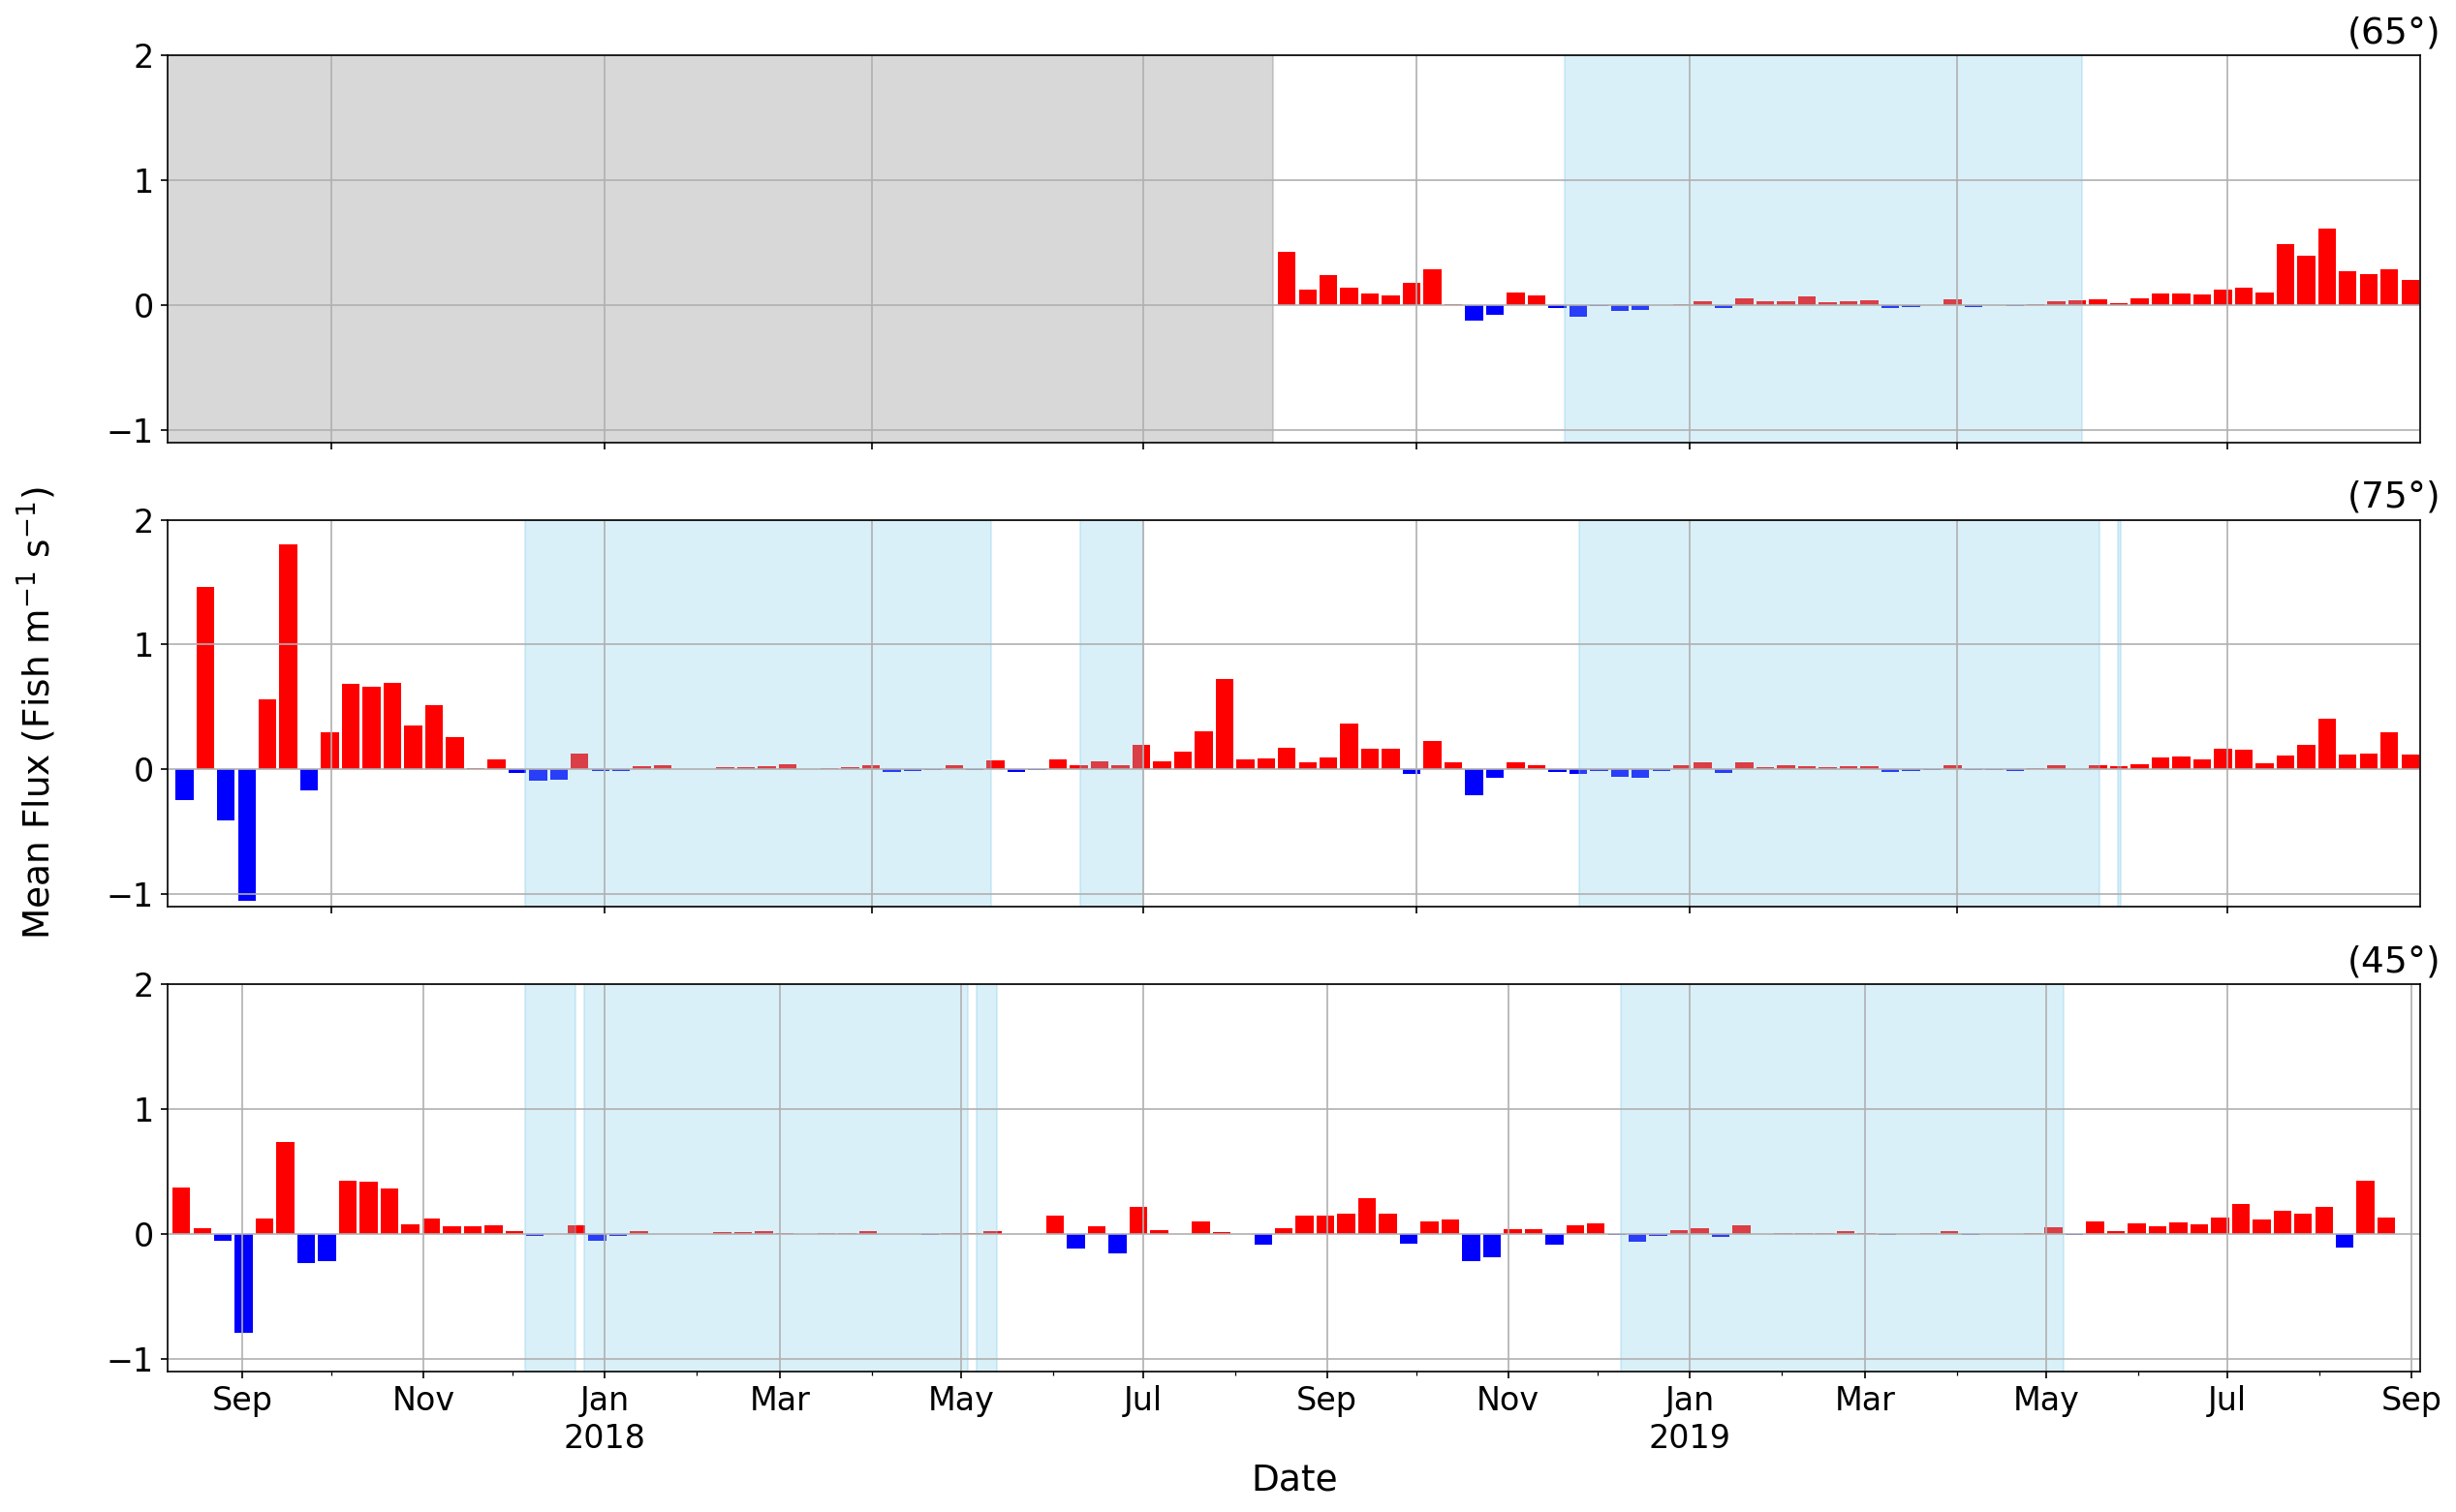

In [117]:
def iceDates(df):
    df['o20']= 0
    df['o20'][(df.iceC > .2)] = 1
    df['shift'] = df['o20'].diff()
    dfShift = df[(df['shift'] != 0)&(~df['shift'].isnull())]
    dates = dfShift.index.values
    iceD = np.array(dates).reshape(int(len(dates)/2),2)
    return iceD

# Ice
dfD1Ice = pd.read_csv('../data/physicalData/C11_NSIDC.csv',parse_dates=['datetime']).set_index('datetime')
dfD2Ice = pd.read_csv('../data/physicalData/C1_NSIDC.csv',parse_dates=['datetime']).set_index('datetime')
dfD3Ice = pd.read_csv('../data/physicalData/C4_NSIDC.csv',parse_dates=['datetime']).set_index('datetime')

plt.rcParams.update({'font.size':16})
f, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(20,12),sharex=True, sharey=True,dpi = 150)

ax1=plt.subplot(311)
a = df3Comb.resample('7D').mean()
ax1.bar(a.index.where(a.fv.ge(0), np.nan)+pd.Timedelta(days=3.5),a.fv.where(a.fv.ge(0), np.nan),color='red',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax1.bar(a.index.where(a.fv.lt(0), np.nan)+pd.Timedelta(days=3.5),a.fv.where(a.fv.lt(0), np.nan),color='blue',width=6)#.plot(color='blue',axes=ax2,fontsize=1
ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax1.grid()
#ax1.text(pd.to_datetime('2019-08-10'),a.fv.max()*1.1,str('('+str(int(np.max(a.linearHead- a.rotateHead)))+'$\degree$)'),fontsize=18)
ax1.text(pd.to_datetime('2019-08-10'),2.1,str('('+str(int(np.max(a.linearHead- a.rotateHead)))+'$\degree$)'),fontsize=18)
ax1.set_xticklabels([])
ax1.xaxis.label.set_visible(False)
ax1.set_ylim([-1.1,2])
#plt.title('Flux from Echosounder',fontsize=18)

iceCov = iceDates(dfD3Ice)
for b in iceCov:
    ax1.axvspan(pd.to_datetime(b[0]), pd.to_datetime(b[1]), ymin=-25, ymax=15, alpha=0.3, color='skyblue')
    
a['ice'] = 0
for b in iceCov:
    a.loc[((a.index >=pd.to_datetime(b[0]))&(a.index <=pd.to_datetime(b[1]))),'ice'] = 1    
print('ice',a[a.ice==1].speedADCP.mean(),'no ice',a[a.ice==0].speedADCP.mean())
    
    
ax2=plt.subplot(312)
a = df2Comb.resample('7D').mean()
ax2.bar(a.index.where(a.fv.ge(0), np.nan)+pd.Timedelta(days=3.5),a.fv.where(a.fv.ge(0), np.nan),color='red',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax2.bar(a.index.where(a.fv.lt(0), np.nan)+pd.Timedelta(days=3.5),a.fv.where(a.fv.lt(0), np.nan),color='blue',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax2.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax2.grid()
ax2.text(pd.to_datetime('2019-08-10'),2.1,str('('+str(int(np.max(a.linearHead- a.rotateHead)))+'$\degree$)'),fontsize=18)
ax2.set_xticklabels([])
ax2.xaxis.label.set_visible(False)
ax2.set_ylim([-1.1,2])
plt.ylabel('Mean Flux (Fish m$^{-1}$ s$^{-1}$)\n',fontsize=18)

iceCov = iceDates(dfD2Ice)
for b in iceCov:
    ax2.axvspan(pd.to_datetime(b[0]), pd.to_datetime(b[1]), ymin=-25, ymax=15, alpha=0.3, color='skyblue')
    
a['ice'] = 0
for b in iceCov:
    a.loc[((a.index >=pd.to_datetime(b[0]))&(a.index <=pd.to_datetime(b[1]))),'ice'] = 1    
print('ice',a[a.ice==1].speedADCP.mean(),'no ice',a[a.ice==0].speedADCP.mean())
    
ax3=plt.subplot(313)
a = df1Comb.resample('7D').mean()
ax3.bar(a.index.where(a.fv.ge(0), np.nan)+pd.Timedelta(days=3.5),a.fv.where(a.fv.ge(0), np.nan),color='red',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax3.bar(a.index.where(a.fv.lt(0), np.nan)+pd.Timedelta(days=3.5),a.fv.where(a.fv.lt(0), np.nan),color='blue',width=6)#.plot(color='blue',axes=ax2,fontsize=1
ax3.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax3.grid()
#ax3.text(pd.to_datetime('2019-08-10'),a.fv.max()*1.2,str('('+str(int(np.max(a.linearHead- a.rotateHead)))+'$\degree$)'),fontsize=18)
ax3.text(pd.to_datetime('2019-08-10'),2.1,str('('+str(int(np.max(a.linearHead- a.rotateHead)))+'$\degree$)'),fontsize=18)
ax3.set_ylim([-1.1,2])
plt.xlabel('Date',fontsize=18)
iceCov = iceDates(dfD1Ice)
for b in iceCov:
    ax3.axvspan(pd.to_datetime(b[0]), pd.to_datetime(b[1]), ymin=-25, ymax=15, alpha=0.3, color='skyblue')

a['ice'] = 0
for b in iceCov:
    a.loc[((a.index >=pd.to_datetime(b[0]))&(a.index <=pd.to_datetime(b[1]))),'ice'] = 1    
print('ice',a[a.ice==1].speedADCP.mean(),'no ice',a[a.ice==0].speedADCP.mean())

fmtAxis(ax3)


<ipython-input-71-e2cc7a102dfa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['o20'][(df.iceC > .2)] = 1
<ipython-input-71-e2cc7a102dfa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['o20'][(df.iceC > .2)] = 1
<ipython-input-71-e2cc7a102dfa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['o20'][(df.iceC > .2)] = 1


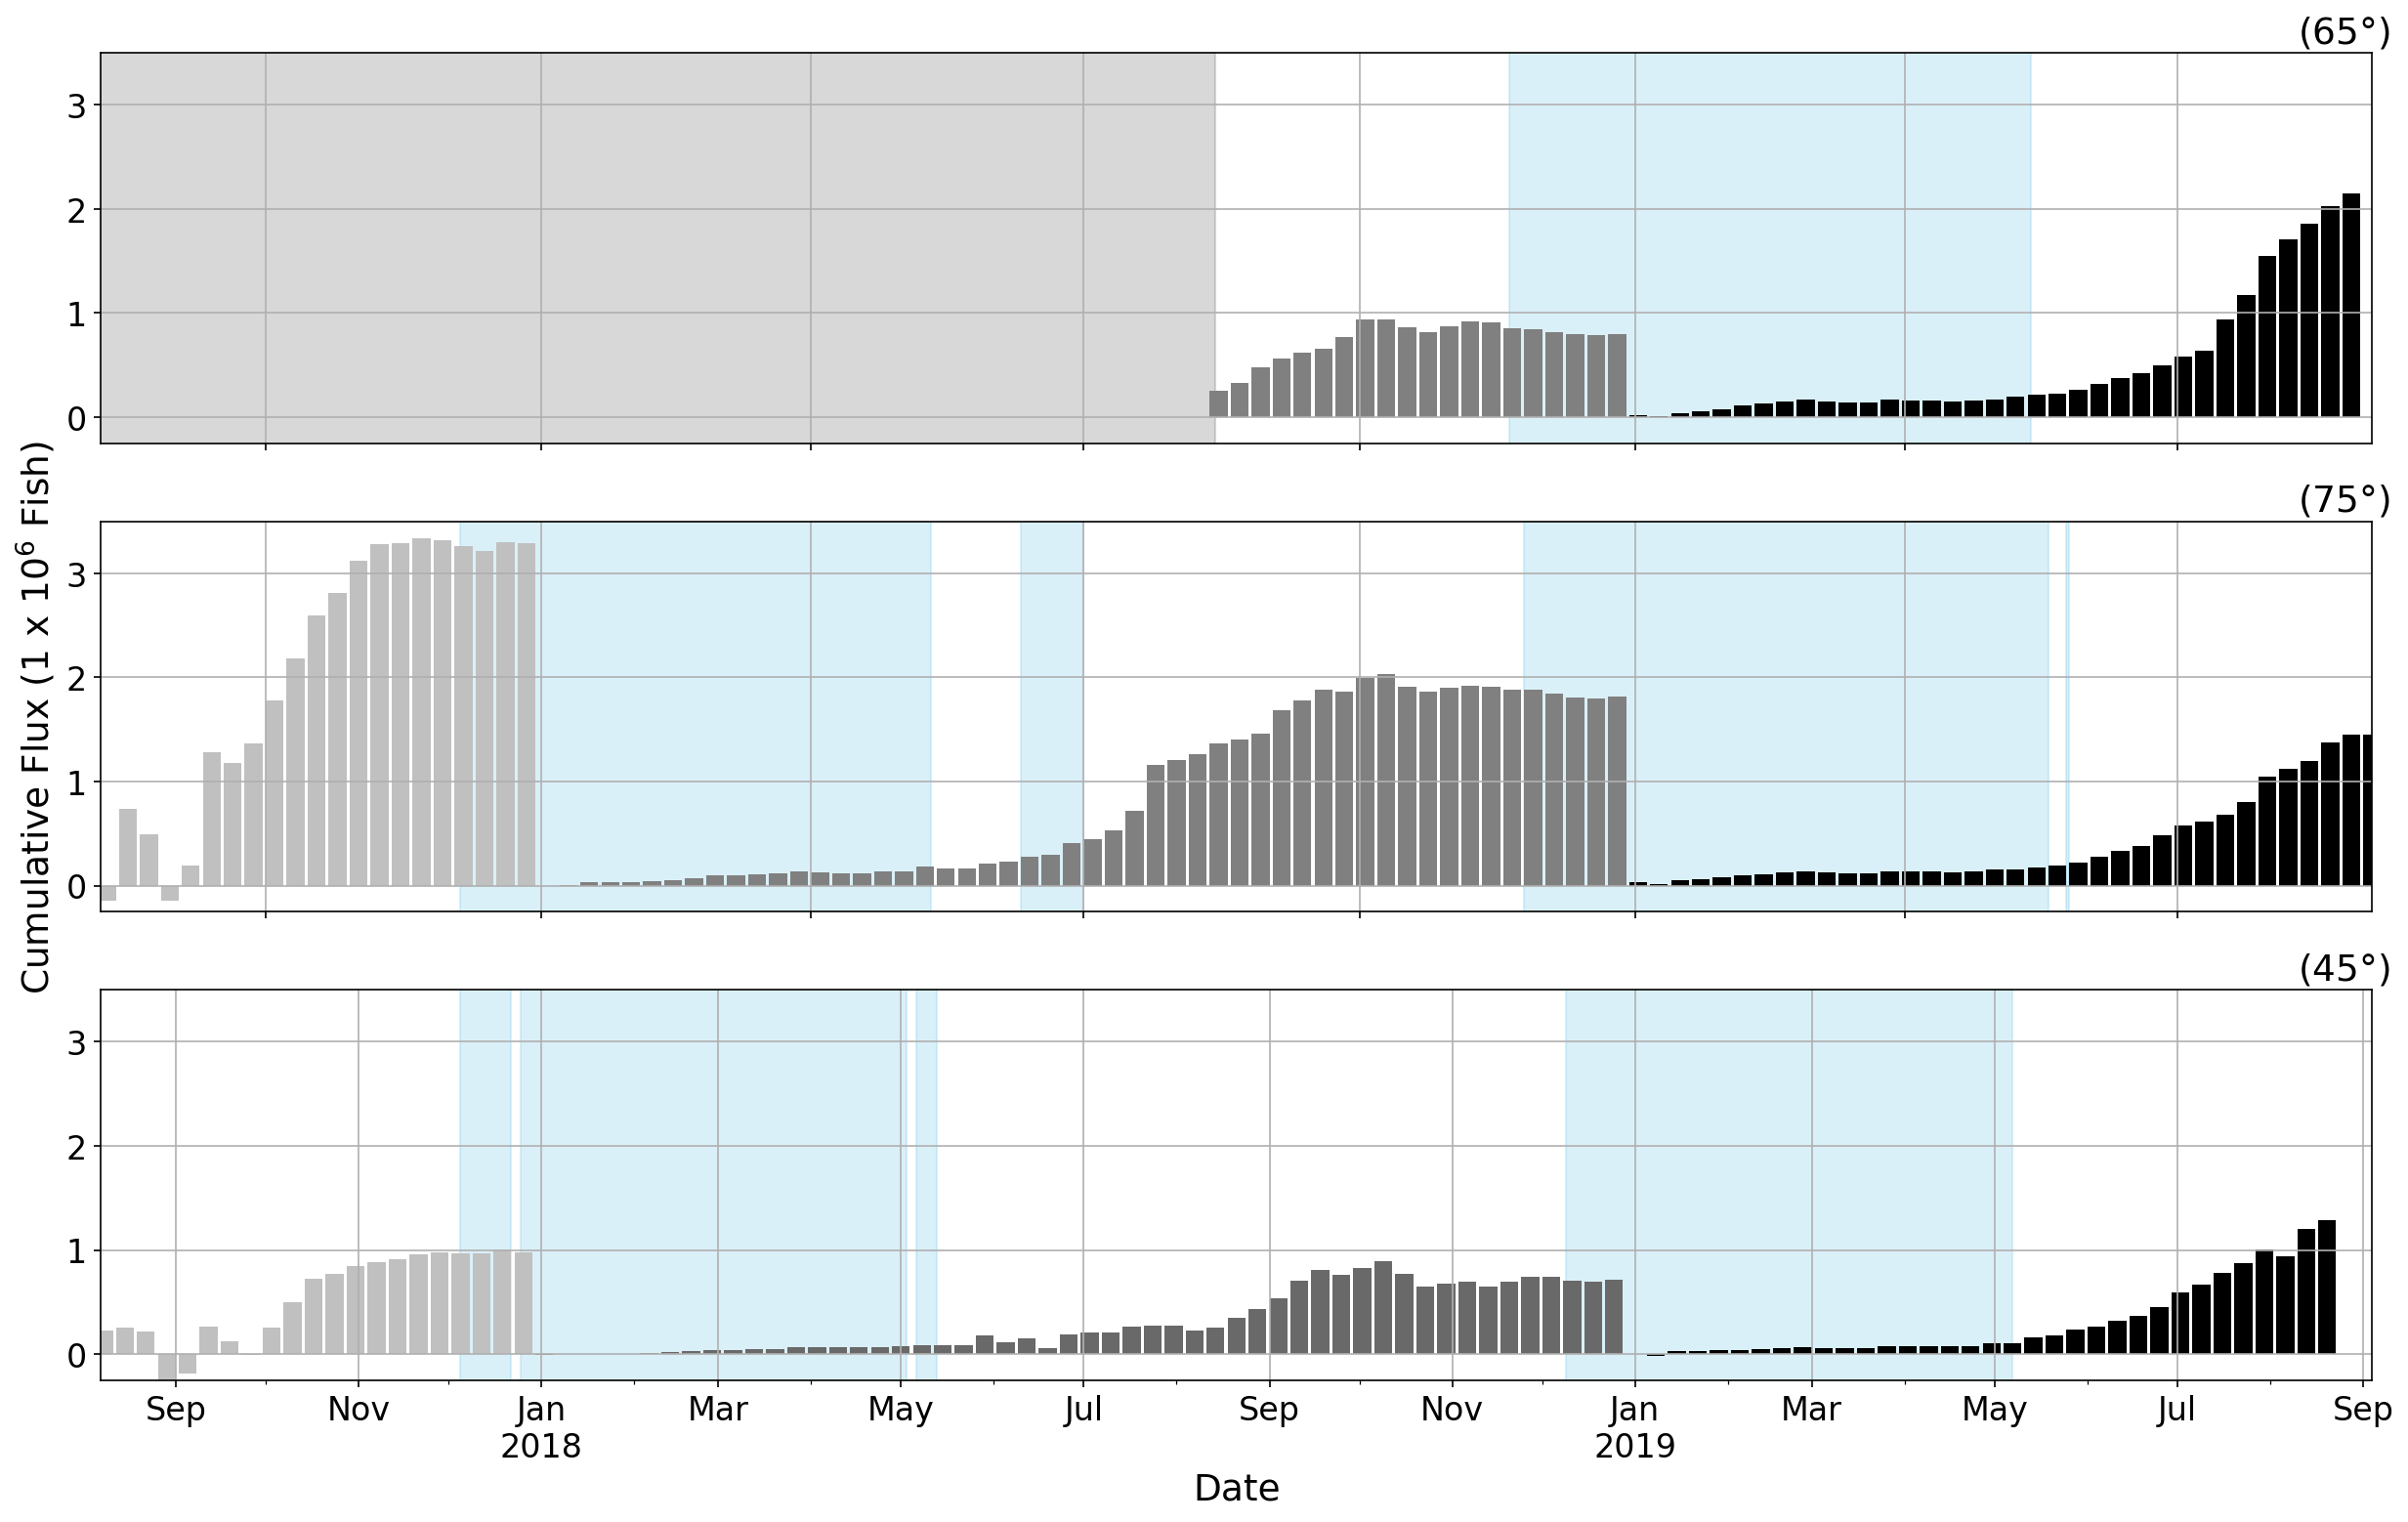

In [71]:
def iceDates(df):
    df['o20']= 0
    df['o20'][(df.iceC > .2)] = 1
    df['shift'] = df['o20'].diff()
    dfShift = df[(df['shift'] != 0)&(~df['shift'].isnull())]
    dates = dfShift.index.values
    iceD = np.array(dates).reshape(int(len(dates)/2),2)
    return iceD

# Ice
dfD1Ice = pd.read_csv('../data/physicalData/C11_NSIDC.csv',parse_dates=['datetime']).set_index('datetime')
dfD2Ice = pd.read_csv('../data/physicalData/C1_NSIDC.csv',parse_dates=['datetime']).set_index('datetime')
dfD3Ice = pd.read_csv('../data/physicalData/C4_NSIDC.csv',parse_dates=['datetime']).set_index('datetime')

plt.rcParams.update({'font.size':16})
f, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(20,12),sharex=True, sharey=True,dpi = 150)

ax1=plt.subplot(311)
a = df3Comb.resample('7D').mean()
ax1.bar(a.index,np.cumsum(a.fv.where(a.index <pd.to_datetime('2018-01-01')))*60*60*24*7/1e6,color='silver',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax1.bar(a.index,np.cumsum(a.fv.where((a.index >pd.to_datetime('2018-01-01'))&(a.index <pd.to_datetime('2019-01-01'))))*60*60*24*7/1e6,color='grey',width=6)#.plot(color='blue',axes=ax2,fontsize=1
ax1.bar(a.index,np.cumsum(a.fv.where(a.index >pd.to_datetime('2019-01-01')))*60*60*24*7/1e6,color='black',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax1.grid()
#ax1.text(pd.to_datetime('2019-08-10'),a.fv.max()*1.1,str('('+str(int(np.max(a.linearHead- a.rotateHead)))+'$\degree$)'),fontsize=18)
ax1.text(pd.to_datetime('2019-08-10'),3.6,str('('+str(int(np.max(a.linearHead- a.rotateHead)))+'$\degree$)'),fontsize=18)
ax1.set_xticklabels([])
ax1.xaxis.label.set_visible(False)
ax1.set_ylim([-.25,3.5])
#plt.title('Flux from Echosounder',fontsize=18)

iceCov = iceDates(dfD3Ice)
for b in iceCov:
    ax1.axvspan(pd.to_datetime(b[0]), pd.to_datetime(b[1]), ymin=-25, ymax=15, alpha=0.3, color='skyblue',zorder = 0)
    
a['ice'] = 0
for b in iceCov:
    a.loc[((a.index >=pd.to_datetime(b[0]))&(a.index <=pd.to_datetime(b[1]))),'ice'] = 1    
#print('ice',a[a.ice==1].speedADCP.mean(),'no ice',a[a.ice==0].speedADCP.mean())
    
    
ax2=plt.subplot(312)
a = df2Comb.resample('7D').mean()
ax2.bar(a.index,np.cumsum(a.fv.where(a.index <pd.to_datetime('2018-01-01')))*60*60*24*7/1e6,color='silver',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax2.bar(a.index,np.cumsum(a.fv.where((a.index >pd.to_datetime('2018-01-01'))&(a.index <pd.to_datetime('2019-01-01'))))*60*60*24*7/1e6,color='grey',width=6)#.plot(color='blue',axes=ax2,fontsize=1
ax2.bar(a.index,np.cumsum(a.fv.where(a.index >pd.to_datetime('2019-01-01')))*60*60*24*7/1e6,color='black',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax2.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax2.grid()
ax2.text(pd.to_datetime('2019-08-10'),3.6,str('('+str(int(np.max(a.linearHead- a.rotateHead)))+'$\degree$)'),fontsize=18)
ax2.set_xticklabels([])
ax2.xaxis.label.set_visible(False)
ax2.set_ylim([-.25,3.5])
plt.ylabel('Cumulative Flux (1 x 10$^{6}$ Fish)',fontsize=18)

iceCov = iceDates(dfD2Ice)
for b in iceCov:
    ax2.axvspan(pd.to_datetime(b[0]), pd.to_datetime(b[1]), ymin=-25, ymax=15, alpha=0.3, color='skyblue',zorder = 0)
    
a['ice'] = 0
for b in iceCov:
    a.loc[((a.index >=pd.to_datetime(b[0]))&(a.index <=pd.to_datetime(b[1]))),'ice'] = 1    
#print('ice',a[a.ice==1].speedADCP.mean(),'no ice',a[a.ice==0].speedADCP.mean())
    
ax3=plt.subplot(313)
a = df1Comb.resample('7D').mean()
ax3.bar(a.index,np.cumsum(a.fv.where(a.index <pd.to_datetime('2018-01-01')))*60*60*24*7/1e6,color='silver',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax3.bar(a.index,np.cumsum(a.fv.where((a.index >pd.to_datetime('2018-01-01'))&(a.index <pd.to_datetime('2019-01-01'))))*60*60*24*7/1e6,color='dimgrey',width=6)#.plot(color='blue',axes=ax2,fontsize=1
ax3.bar(a.index,np.cumsum(a.fv.where(a.index >pd.to_datetime('2019-01-01')))*60*60*24*7/1e6,color='black',width=6)#.plot(color='blue',axes=ax2,fontsize=18)
ax3.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax3.grid()
#ax3.text(pd.to_datetime('2019-08-10'),a.fv.max()*1.2,str('('+str(int(np.max(a.linearHead- a.rotateHead)))+'$\degree$)'),fontsize=18)
ax3.text(pd.to_datetime('2019-08-10'),3.6,str('('+str(int(np.max(a.linearHead- a.rotateHead)))+'$\degree$)'),fontsize=18)
ax3.set_ylim([-.25,3.5])
plt.xlabel('Date',fontsize=18)
iceCov = iceDates(dfD1Ice)
for b in iceCov:
    ax3.axvspan(pd.to_datetime(b[0]), pd.to_datetime(b[1]), ymin=-25, ymax=15, alpha=0.3, color='skyblue',zorder = 0)

a['ice'] = 0
for b in iceCov:
    a.loc[((a.index >=pd.to_datetime(b[0]))&(a.index <=pd.to_datetime(b[1]))),'ice'] = 1    
#print('ice',a[a.ice==1].speedADCP.mean(),'no ice',a[a.ice==0].speedADCP.mean())

fmtAxis(ax3)


In [118]:
uf = glob('../data/physicalData/wind/uwnd*')
vf = glob('../data/physicalData/wind/vwnd*')
dsU = xr.open_mfdataset(uf)
dsV = xr.open_mfdataset(vf)
dsWind = dsU.merge(dsV)
dsWind.sel(lat=70,lon=195)
dfWind =dsWind.sel(lat=70,lon=195).to_dataframe()

5.529293060302734
5.539155960083008
5.581207275390625


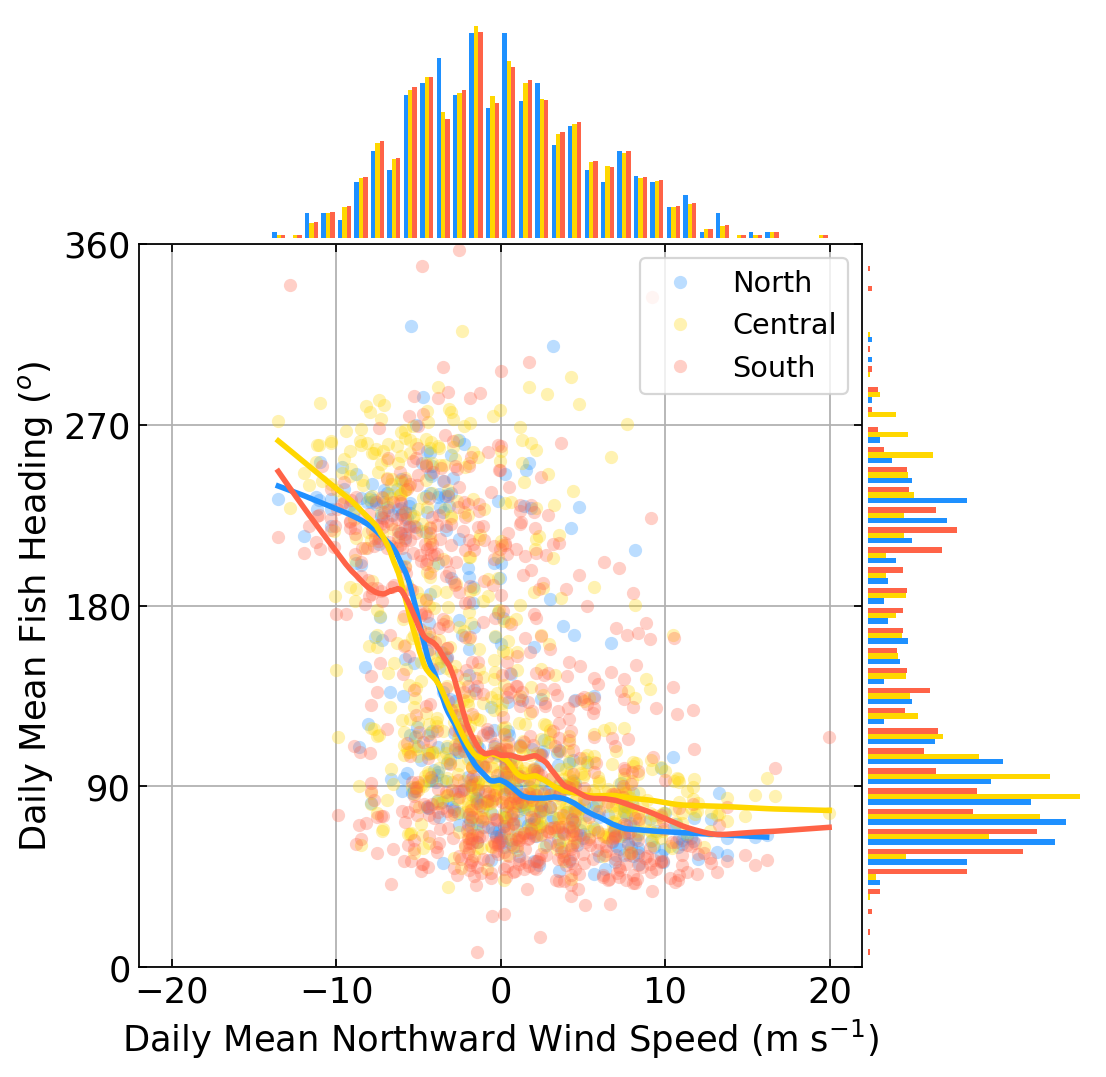

In [131]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.patheffects as pe


# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(7, 7),dpi=159)
plt.rcParams.update({'font.size':16})
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

col=['dodgerblue','gold','tomato']
ct = 0
x,y = [],[]
for df in [df3Comb, df2Comb, df1Comb]:
    b = mp.wind_speed(dfWind.uwnd.values*units('m/s'),dfWind.vwnd.values*units('m/s'))
    dfWind['dir'] = b.magnitude
    a = pd.merge_asof(left=df.resample('1D').mean(),right=dfWind.resample('1D').mean(),right_index=True,left_index=True,direction='nearest')
    a = a[~a.linearHead.isnull()]
    ax_scatter.plot(a.vwnd,a.linearHead,'.',color = col[ct],alpha=0.3,markersize=12,markeredgecolor='None')
    print(np.std(a.vwnd))
    #linFit = olsFit(a.vwnd,a.linearHead)
    #print(linFit)
    #ax_scatter.plot([min(a.vwnd),max(a.vwnd)],[(linFit[1]*min(a.vwnd))+linFit[0],(linFit[1]*max(a.vwnd))+linFit[0]],linestyle='--',color=col[ct],label='_nolegend_')
    filtered = lowess( a.linearHead,a.vwnd, frac=.2)
    #ax_scatter.plot(filtered[:,0], filtered[:,1],linestyle='--',color=col[ct], lw=1.5, path_effects=[pe.Stroke(linewidth=2.5, foreground='k'), pe.Normal()],label='_nolegend_',zorder=10)
    ax_scatter.plot(filtered[:,0], filtered[:,1],linestyle='-',color=col[ct], lw=2.5,label='_nolegend_',zorder=10)
    ct+=1
    x.append(a.vwnd.values)
    y.append(a.linearHead.values)
    

ax_scatter.legend(['North','Central','South'],fontsize=13)
ax_scatter.set_yticks([0,90,180,270,360])
ax_scatter.grid()
# now determine nice limits by hand:
binwidth = 0.25
#lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim((-22,22))
ax_scatter.set_ylim((0,360))
ax_scatter.set_xlabel('Daily Mean Northward Wind Speed (m s$^{-1}$)')
ax_scatter.set_ylabel('Daily Mean Fish Heading ($^{o}$)')

ax_histx.hist(x, bins=np.arange(-15,25,1),density=True,color=col)
ax_histy.hist(y, bins=np.arange(0,360,10), orientation='horizontal',density=True,color=col)

ax_histx.set_xlim(ax_scatter.get_xlim())
#ax_histx.set_yticks([0,0.05])
ax_histx.set_axis_off()
ax_histy.set_ylim(ax_scatter.get_ylim())
#ax_histy.set_yticks([0,90,180,270,360])
ax_histy.set_axis_off()

plt.show()

In [103]:
dfBs = evFuncs.evExports.readEvExports(filesD1Y1)
dfT = readTracks('../data/analysisFiles/TrackRegions1_linear3.csv')
dfADCP = pmelTransport(['../data/physicalData/PMEL_2017_17ckp11a_wcp_vel.nc'])
df1 = combF(dfBs,dfT, dfADCP,47, rotate=True,deg = 45)

print(np.sum(df1.resample('7D').mean().fv*(60*60*24*7)))
print(df1.fv.mean())

dfBs = evFuncs.evExports.readEvExports(filesD2Y1)
dfT = readTracks('../data/analysisFiles/TrackRegions2_linear3.csv')
dfADCP = pmelTransport(['../data/physicalData/PMEL_2017_17ckp1a_wcp_vel.nc'])
df1 = combF(dfBs,dfT, dfADCP,44, rotate=True,deg = 75)

print(np.sum(df1.resample('7D').mean().fv*(60*60*24*7)))
print(df1.fv.mean())

dfBs = evFuncs.evExports.readEvExports(filesD1Y2)
dfT = readTracks('../data/analysisFiles/TrackRegions4_linear3.csv')
dfADCP = pmelTransport(['../data/physicalData/PMEL_2018_18ckp11a_wcp_vel.nc'])
df1 = combF(dfBs,dfT, dfADCP,47, rotate=True,deg = 45)

print(np.sum(df1.resample('7D').mean().fv*(60*60*24*7)))
print(df1.fv.mean())

dfBs = evFuncs.evExports.readEvExports(filesD2Y2)
dfT = readTracks('../data/analysisFiles/TrackRegions5_linear3.csv')
dfADCP = pmelTransport(['../data/physicalData/PMEL_2018_18ckp1a_wcp_vel.nc'])
df1 = combF(dfBs,dfT, dfADCP,44, rotate=True,deg = 75)

print(np.sum(df1.resample('7D').mean().fv*(60*60*24*7)))
print(df1.fv.mean())


dfBs = evFuncs.evExports.readEvExports(filesD3Y2)
dfT = readTracks('../data/analysisFiles/TrackRegions6_linear3.csv')
dfADCP = pmelTransport(['../data/physicalData/PMEL_2018_18ckp4a_wcp_vel.nc'])
df1 = combF(dfBs,dfT, dfADCP,49, rotate=True,deg = 65)

print(np.sum(df1.resample('7D').mean().fv*(60*60*24*7)))
print(df1.fv.mean())


45
1257749.0933090672
0.04717996345951032
75
4546781.920124718
0.15922516127020472
45
1921993.3172410624
0.05462078836659671
75
2002328.4357801408
0.06386758327743142
65
2947342.742980653
0.08686122789484105


(<matplotlib.patches.Rectangle at 0x1a309d651c0>,
 (<matplotlib.patches.ConnectionPatch at 0x1a309d65ca0>,
  <matplotlib.patches.ConnectionPatch at 0x1a309d60610>))

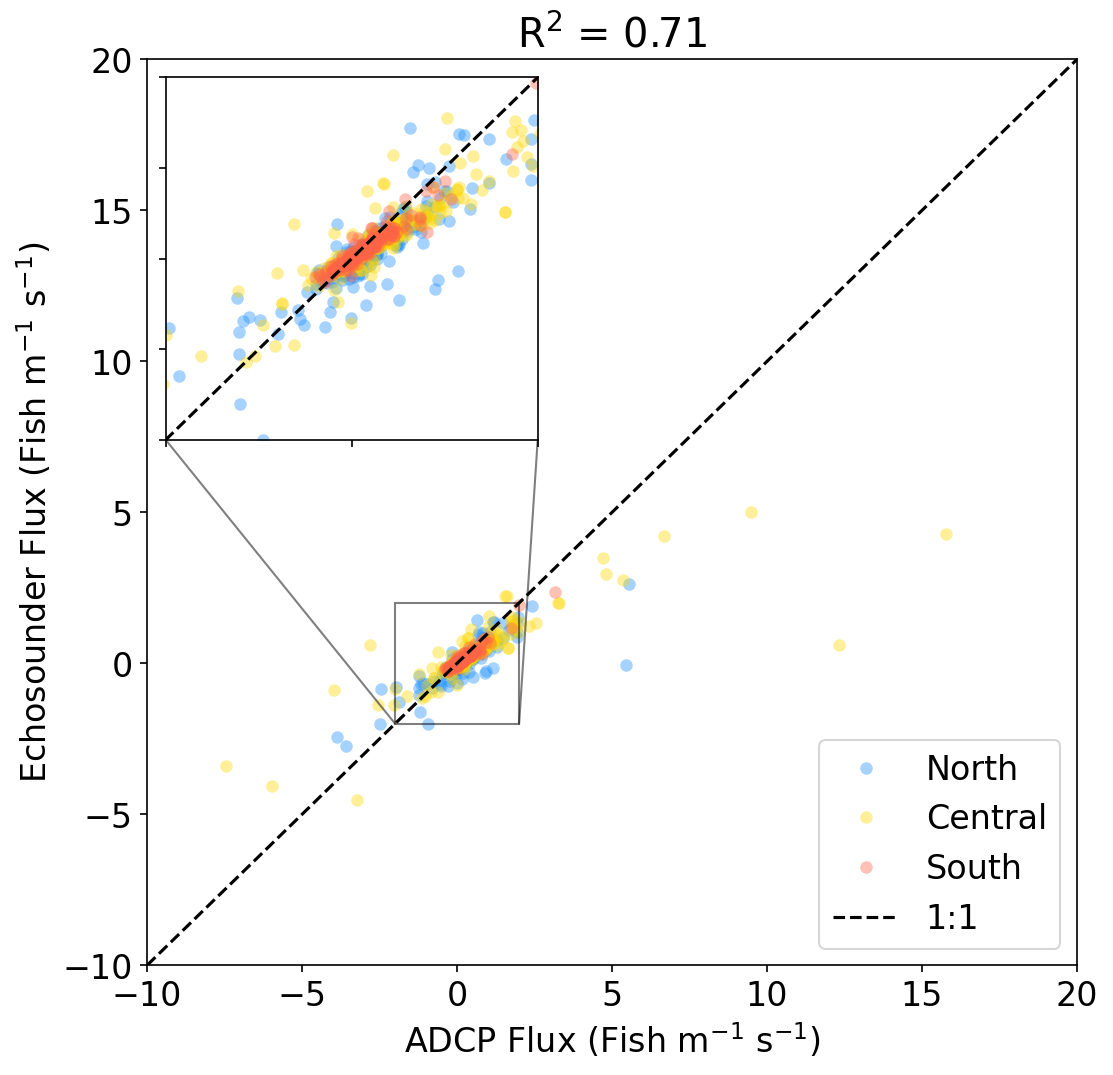

In [119]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize = (8,8),dpi=150)
ax = plt.subplot(111)
ax.plot(df1Comb.resample('1D').mean().fvADCProtated, df1Comb.resample('1D').mean().fv,'.',color='dodgerblue',markersize=12, alpha=0.4,markeredgecolor='None')
ax.plot(df2Comb.resample('1D').mean().fvADCProtated, df2Comb.resample('1D').mean().fv,'.',color='gold',markersize=12, alpha=0.4,markeredgecolor='None')
ax.plot(df3Comb.resample('1D').mean().fvADCProtated, df3Comb.resample('1D').mean().fv,'.',color='tomato',markersize=12, alpha=0.4,markeredgecolor='None')
ax.axis([-10,20,-10,20])
ax.plot([-10,20],[-10,20],'--k')
ax.set_xlabel('ADCP Flux (Fish m$^{-1}$ s$^{-1}$)')
ax.set_ylabel('Echosounder Flux (Fish m$^{-1}$ s$^{-1}$)')
plt.legend(['North','Central','South','1:1'])
a = np.concatenate([df1Comb.resample('1D').mean().fvADCProtated,df2Comb.resample('1D').mean().fvADCProtated,df3Comb.resample('1D').mean().fvADCProtated])
b = np.concatenate([df1Comb.resample('1D').mean().fv,df2Comb.resample('1D').mean().fv,df3Comb.resample('1D').mean().fv])
pr = np.round(np.corrcoef(a[~np.isnan(a)],b[~np.isnan(a)])[0][1],3)
plt.title('R$^{2}$ = '+str(np.round(pr**2,2)))


axins = ax.inset_axes([0.02, 0.58, 0.4, 0.4])
axins.plot(df1Comb.resample('1D').mean().fvADCProtated, df1Comb.resample('1D').mean().fv,'.',color='dodgerblue',markersize=12, alpha=0.4,markeredgecolor='None')
axins.plot(df2Comb.resample('1D').mean().fvADCProtated, df2Comb.resample('1D').mean().fv,'.',color='gold',markersize=12, alpha=0.4,markeredgecolor='None')
axins.plot(df3Comb.resample('1D').mean().fvADCProtated, df3Comb.resample('1D').mean().fv,'.',color='tomato',markersize=12, alpha=0.4,markeredgecolor='None')
axins.plot([-15,15],[-15,15],'--k')
## sub region of the original image
x1, x2, y1, y2 = -2,2,-2,2
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')

ax.indicate_inset_zoom(axins, edgecolor="black")

In [46]:
df1Comb = combF(dfD1,dfD1T, dfD1ADCP,1)#47)
df2Comb = combF(dfD2,dfD2T, dfD2ADCP,1)#44)
df3Comb = combF(dfD3,dfD3T, dfD3ADCP,1)#49)

uf = glob('../data/physicalData/wind/uwnd*')
vf = glob('../data/physicalData/wind/vwnd*')
dsU = xr.open_mfdataset(uf)
dsV = xr.open_mfdataset(vf)
dsWind = dsU.merge(dsV)
dsWind.sel(lat=70,lon=195)
dfWind =dsWind.sel(lat=70,lon=195).to_dataframe()

Text(0.5, 0, 'Date')

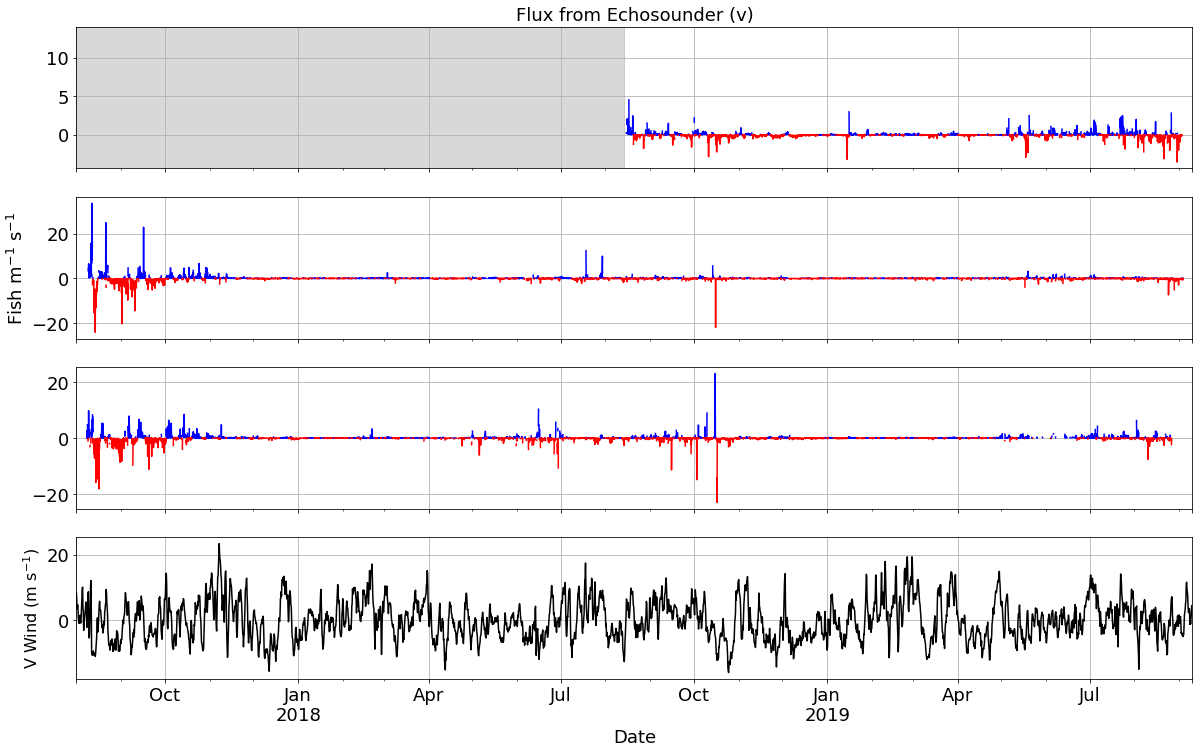

In [59]:
f, [ax1,ax2,ax3,ax4] = plt.subplots(4,1,figsize=(20,12),sharex=True, sharey=True)

ax1=plt.subplot(411)
a = df3Comb
a.fv.where(a.fv.ge(0), np.nan).plot(color='blue',axes=ax1,fontsize=18)
a.fv.where(a.fv.lt(0), np.nan).plot(color='red', axes=ax1,fontsize=18)
ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
ax1.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax1.grid()
ax1.set_xticklabels([])
ax1.xaxis.label.set_visible(False)
plt.title('Flux from Echosounder (v)',fontsize=18)


col = 'tomato'
ax2=plt.subplot(412)
a = df2Comb
a.fv.where(a.fv.ge(0), np.nan).plot(color='blue',axes=ax2,fontsize=18)
a.fv.where(a.fv.lt(0), np.nan).plot(color='red', axes=ax2,fontsize=18)
#a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='k')
#if pltDict[df.name][0]==1:
#    ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
#ax1.set_ylim([-60,pltDict[df.name][2]])
##ax1.set_yticks([0,1000,2000,3000])
ax2.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax2.grid()
#ax1.legend(['Wakeup Mean','Daily Mean'], fontsize=18)
ax2.set_xticklabels([])
ax2.xaxis.label.set_visible(False)
plt.ylabel('Fish m$^{-1}$ s$^{-1}$',fontsize=18)

col = 'tomato'
ax3=plt.subplot(413)
a = df1Comb
a.fv.where(a.fv.ge(0), np.nan).plot(color='blue',axes=ax3,fontsize=18)
a.fv.where(a.fv.lt(0), np.nan).plot(color='red', axes=ax3,fontsize=18)
#a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='k')
#if pltDict[df.name][0]==1:
#    ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
#ax1.set_ylim([-60,pltDict[df.name][2]])
##ax1.set_yticks([0,1000,2000,3000])
ax3.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax3.grid()
#ax1.legend(['Wakeup Mean','Daily Mean'], fontsize=18)
ax3.set_xticklabels([])
ax3.xaxis.label.set_visible(False)
#plt.ylabel('70 kHz Backscatter\n(s$_{A}$, m$^{2}$ nmi$^{-2}$)',fontsize=16)

ax4=plt.subplot(414)
dfWind.vwnd.plot(label='Wakeups',legend=False,fontsize='18',axes=ax4, color='k')
ax4.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax4.grid()
ax4.set_ylabel('V Wind (m s$^{-1}$)')
plt.xlabel('Date',fontsize=18)

Text(0.5, 0, 'Date')

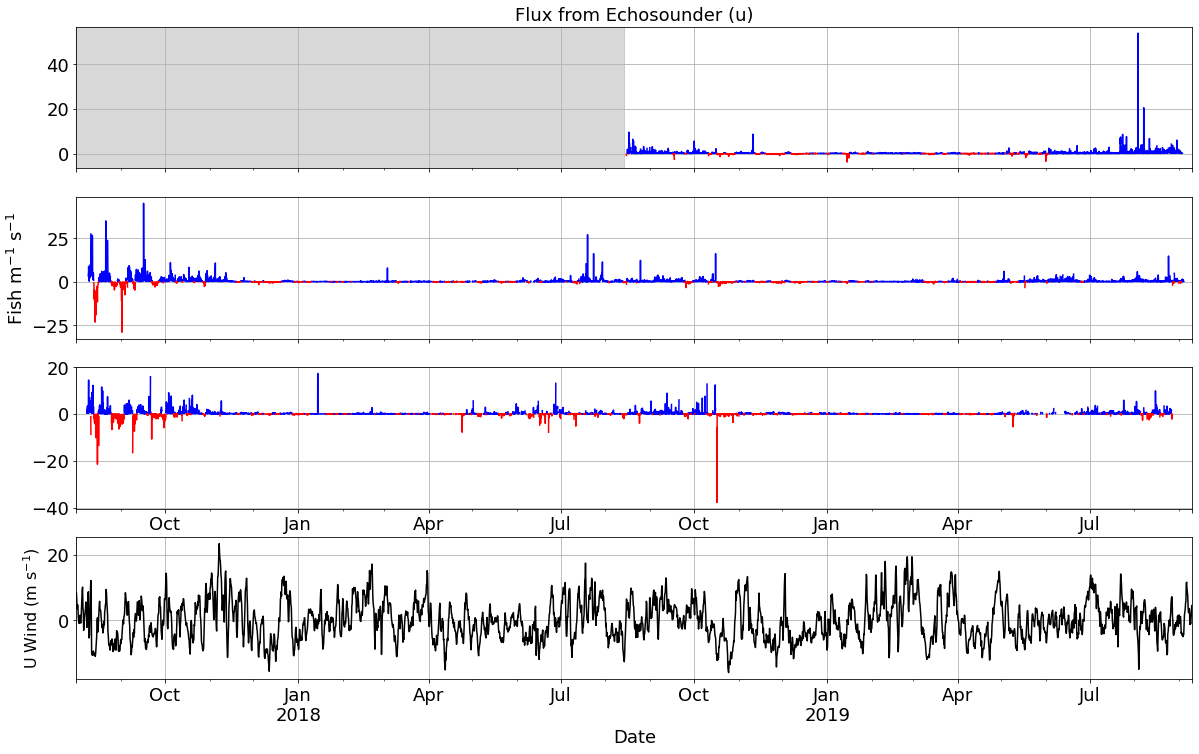

In [61]:
f, [ax1,ax2,ax3,ax4] = plt.subplots(4,1,figsize=(20,12),sharex=True, sharey=True)

ax1=plt.subplot(411)
a = df3Comb
a.fu.where(a.fu.ge(0), np.nan).plot(color='blue',axes=ax1,fontsize=18)
a.fu.where(a.fu.lt(0), np.nan).plot(color='red', axes=ax1,fontsize=18)
ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
ax1.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax1.grid()
ax1.set_xticklabels([])
ax1.xaxis.label.set_visible(False)
plt.title('Flux from Echosounder (u)',fontsize=18)


col = 'tomato'
ax2=plt.subplot(412)
a = df2Comb
a.fu.where(a.fu.ge(0), np.nan).plot(color='blue',axes=ax2,fontsize=18)
a.fu.where(a.fu.lt(0), np.nan).plot(color='red', axes=ax2,fontsize=18)
#a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='k')
#if pltDict[df.name][0]==1:
#    ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
#ax1.set_ylim([-60,pltDict[df.name][2]])
##ax1.set_yticks([0,1000,2000,3000])
ax2.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax2.grid()
#ax1.legend(['Wakeup Mean','Daily Mean'], fontsize=18)
ax2.set_xticklabels([])
ax2.xaxis.label.set_visible(False)
plt.ylabel('Fish m$^{-1}$ s$^{-1}$',fontsize=18)

col = 'tomato'
ax3=plt.subplot(413)
a = df1Comb
a.fu.where(a.fu.ge(0), np.nan).plot(color='blue',axes=ax3,fontsize=18)
a.fu.where(a.fu.lt(0), np.nan).plot(color='red', axes=ax3,fontsize=18)
#a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='k')
#if pltDict[df.name][0]==1:
#    ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
#ax1.set_ylim([-60,pltDict[df.name][2]])
##ax1.set_yticks([0,1000,2000,3000])
ax3.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax3.grid()
#ax1.legend(['Wakeup Mean','Daily Mean'], fontsize=18)
#ax1.set_xticklabels([])
#ax1.xaxis.label.set_visible(False)
#plt.ylabel('70 kHz Backscatter\n(s$_{A}$, m$^{2}$ nmi$^{-2}$)',fontsize=16)
plt.xlabel('Date',fontsize=18)

ax4=plt.subplot(414)
dfWind.vwnd.plot(label='Wakeups',legend=False,fontsize='18',axes=ax4, color='k')
ax4.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
ax4.grid()
ax4.set_ylabel('U Wind (m s$^{-1}$)')
plt.xlabel('Date',fontsize=18)

## Cross-correlation

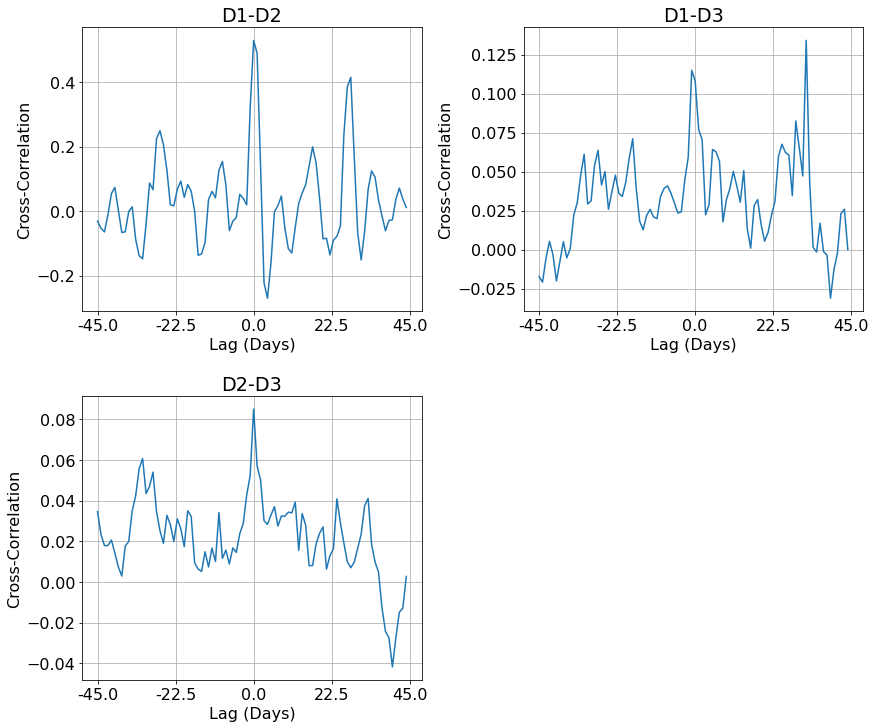

In [749]:
dfvs = df1Comb[['fvADCP']].rename(columns={'fvADCP':'fvADCP1'}).join(df2Comb[['fvADCP']].rename(columns={'fvADCP':'fvADCP2'})).join(df3Comb[['fvADCP']].rename(columns={'fvADCP':'fvADCP3'}))
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

    

days = 45

fig = plt.figure(figsize=(14,12))

d1 = dfvs.fvADCP1.resample('1D').sum()
d2 = dfvs.fvADCP2.resample('1D').sum()
rs = [crosscorr(d1,d2, lag) for lag in range(-days,days)]
ax = plt.subplot(221)
ax.plot(rs)
ax.set_xticks(np.arange(0,(days*2)+1,days/2))
ax.set_xticklabels([str(a) for a in np.arange(-days,(days)+1,days/2)]);
ax.set_ylabel('Cross-Correlation')
ax.set_xlabel('Lag (Days)')
ax.grid()
plt.title('D1-D2')

d1 = dfvs.fvADCP1.resample('1D').sum()
d2 = dfvs.fvADCP3.resample('1D').sum()
rs = [crosscorr(d1,d2, lag) for lag in range(-days,days)]
ax = plt.subplot(222)
ax.plot(rs)
ax.set_xticks(np.arange(0,(days*2)+1,days/2))
ax.set_xticklabels([str(a) for a in np.arange(-days,(days)+1,days/2)]);
ax.set_ylabel('Cross-Correlation')
ax.set_xlabel('Lag (Days)')
ax.grid()
plt.title('D1-D3')


d1 = dfvs.fvADCP2.resample('1D').sum()
d2 = dfvs.fvADCP3.resample('1D').sum()
rs = [crosscorr(d1,d2, lag) for lag in range(-days,days)]
ax = plt.subplot(223)
ax.plot(rs)
ax.set_xticks(np.arange(0,(days*2)+1,days/2))
ax.set_xticklabels([str(a) for a in np.arange(-days,(days)+1,days/2)]);
ax.set_ylabel('Cross-Correlation')
ax.set_xlabel('Lag (Days)')
ax.grid()
plt.title('D2-D3')
plt.subplots_adjust(wspace=0.3,hspace=0.3)

Text(0.5, 1.0, 'D2-D3')

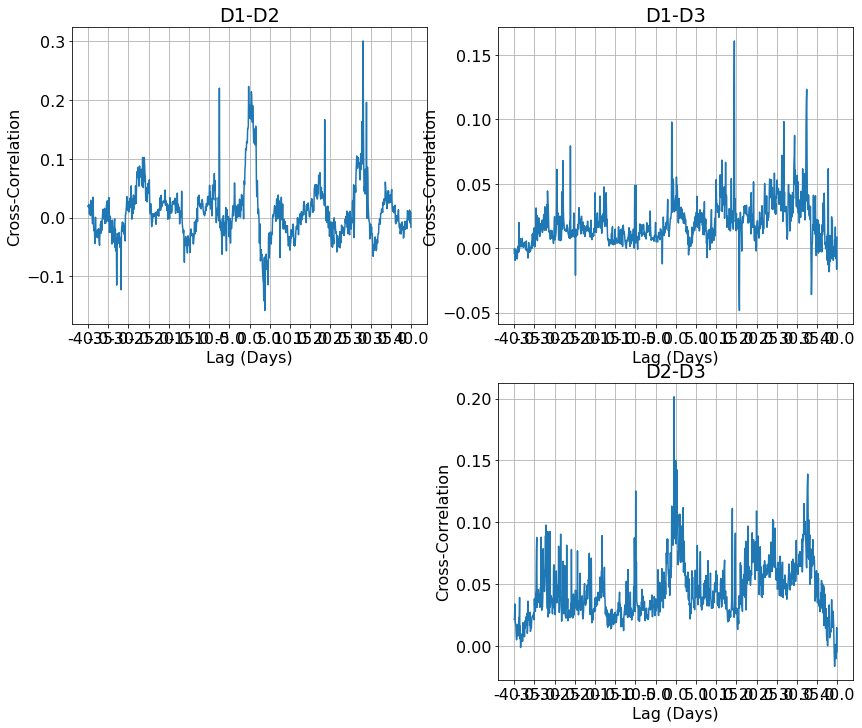

In [750]:
days = 40

fig = plt.figure(figsize=(14,12))

d1 = dfvs.fvADCP1
d2 = dfvs.fvADCP2
rs = [crosscorr(d1,d2, lag) for lag in range(-days*12,days*12)]
ax = plt.subplot(221)
ax.plot(rs)
ax.set_xticks(np.arange(0,(days*12*2)+1,60))
ax.set_xticklabels([str(a) for a in np.arange(-days*12,(days*12)+1,60)/12]);
ax.set_ylabel('Cross-Correlation')
ax.set_xlabel('Lag (Days)')
ax.grid()
plt.title('D1-D2')

d1 = dfvs.fvADCP1
d2 = dfvs.fvADCP3
rs = [crosscorr(d1,d2, lag) for lag in range(-days*12,days*12)]
ax = plt.subplot(222)
ax.plot(rs)
ax.set_xticks(np.arange(0,(days*12*2)+1,60))
ax.set_xticklabels([str(a) for a in np.arange(-days*12,(days*12)+1,60)/12]);
ax.set_ylabel('Cross-Correlation')
ax.set_xlabel('Lag (Days)')
ax.grid()
plt.title('D1-D3')


d1 = dfvs.fvADCP2
d2 = dfvs.fvADCP3
rs = [crosscorr(d1,d2, lag) for lag in range(-days*12,days*12)]
ax = plt.subplot(224)
ax.plot(rs)
ax.set_xticks(np.arange(0,(days*12*2)+1,60))
ax.set_xticklabels([str(a) for a in np.arange(-days*12,(days*12)+1,60)/12]);
ax.set_ylabel('Cross-Correlation')
ax.set_xlabel('Lag (Days)')
ax.grid()
plt.title('D2-D3')